In [147]:
import networkx as nx
from shapely.geometry import Polygon,LineString,Point
from shapely.ops import split
import numpy as np
import matplotlib.pyplot as plt

In [148]:
def make_graph(point_1, point_2, obstacles, path = False):
    plt.scatter(point_1[0], point_1[1], c="blue")
    plt.scatter(point_2[0], point_2[1], c="blue")
    plt.plot([point_1[0], point_2[0]],[point_1[1], point_2[1]], c="gray")
    for obstacle_id, point in obstacles.items():
        points = point.exterior.coords
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.7)
    if path:
        for i in range(len(path) - 1):
            plt.plot([path[i][0],path[i+1][0]],[path[i][1],path[i+1][1]],c="green")
    plt.grid(True)
    plt.show()

In [149]:
def line_intersect(line, obstacle):
    parts = split(obstacle, line)

    count = len([geoms for geoms in parts.geoms])

    return count != 1

In [150]:
def calculate_distance(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sqrt(np.sum((point1 - point2)**2))

In [151]:
def create_shortest_path(point_1, point_2, obstacle):
    intersections = obstacle.exterior.coords

    # Create a graph
    G = nx.Graph()

    # Add nodes for each point in the space
    G.add_node(tuple(point_1))

    for inter_point in intersections:
        G.add_node(tuple(inter_point))
    
    G.add_node(tuple(point_2))

    # Add edges between adjacent points
    for cur in G.nodes():
        for next in G.nodes():
            if cur == next:
                continue
            line = LineString([cur, next])
            if not line_intersect(line, obstacle):
                G.add_edge(cur, next)

    # Find the shortest path using A*
    start = tuple(point_1)
    goal = tuple(point_2)
    path = nx.astar_path(G, start, goal, heuristic=calculate_distance)

    # graphical representation
    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, node_color='lightgray', with_labels=True)
    nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color='green')
    nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color='red')
    nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], edge_color='blue', width=2)
    plt.title('Path Planning with Obstacle Avoidance')
    plt.show()

    return path

In [152]:
def create_path(source, destination, obstacles):
    line = LineString([source, destination])
    obstacle_free_path = True

    # Check for obstacle intersection
    for obs_id, obstacle in obstacles.items():
        if line_intersect(line, obstacle):
            obstacle_free_path = False
            # Recursively find path around the obstacle
            path_around_obstacle = create_shortest_path(source, destination, obstacle)
            # Concatenate the paths
            path = []
            for i in range(len(path_around_obstacle) - 1):
                path.extend(create_path(path_around_obstacle[i], path_around_obstacle[i + 1], obstacles))
            return path

    # Base case: no obstacle in the line
    if obstacle_free_path:
        return [source, destination]

    return []


## Input

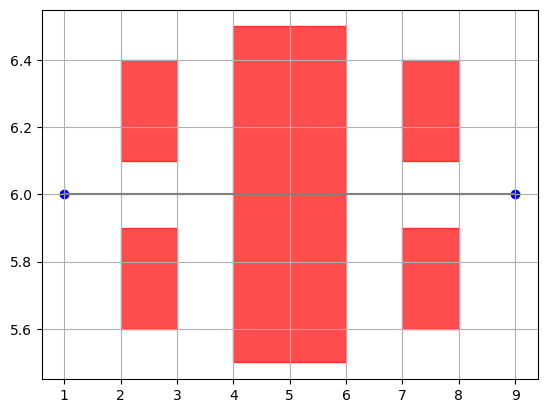

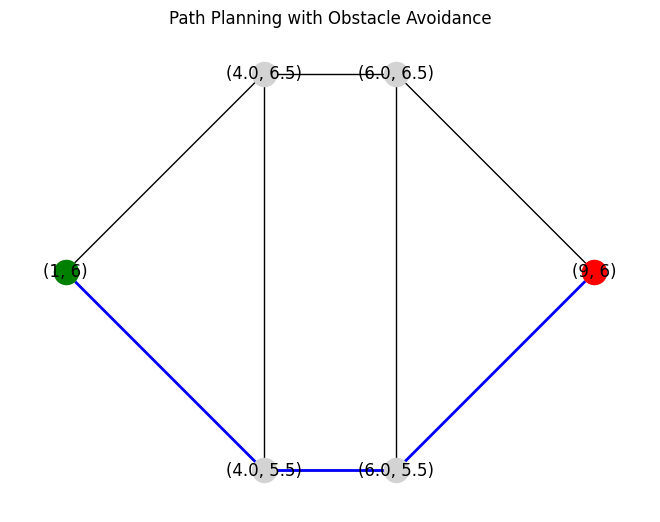

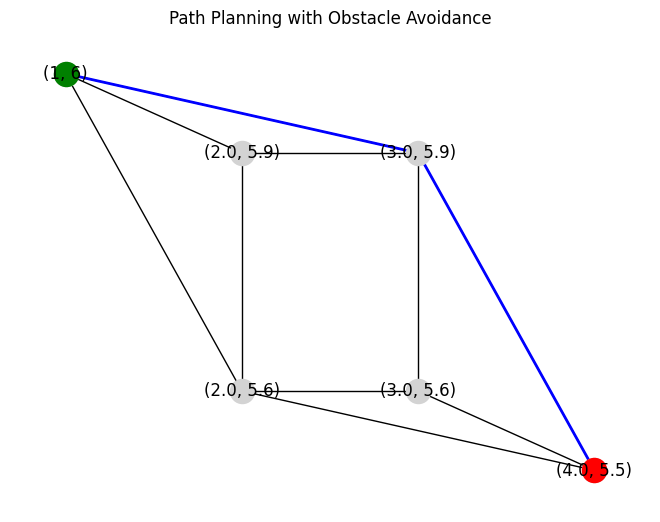

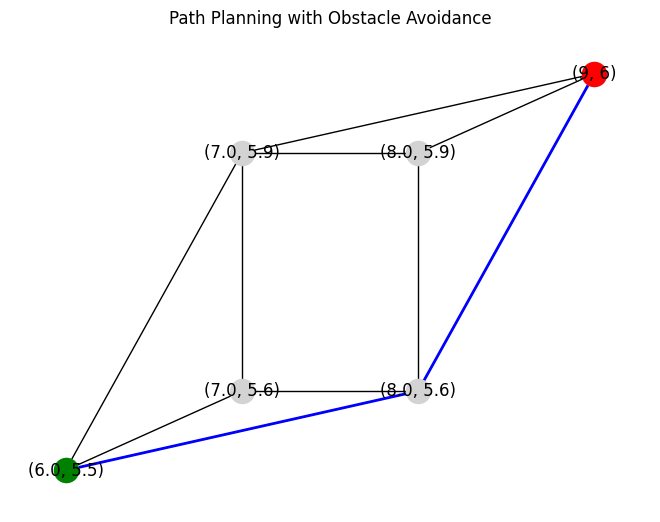

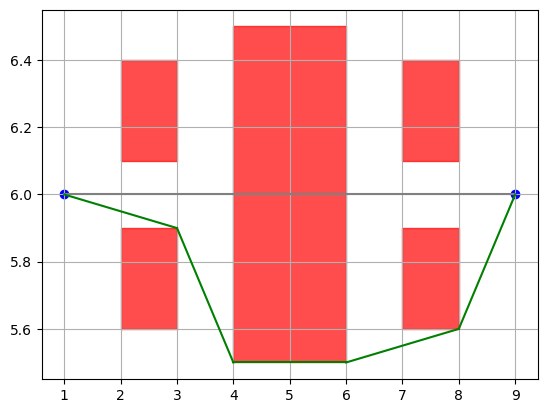

In [153]:
point_1 = [1,6]
point_2 = [9,6]

obstacles = {
    0: Polygon([(4,5.5),(6,5.5),(6,6.5),(4,6.5),(4,5.5)]),
    1: Polygon([(2,6.1),(3,6.1),(3,6.4),(2,6.4),(2,6.1)]),
    2: Polygon([(2,5.6),(3,5.6),(3,5.9),(2,5.9),(2,5.6)]),
    3: Polygon([(7,6.1),(8,6.1),(8,6.4),(7,6.4),(7,6.1)]),
    4: Polygon([(7,5.6),(8,5.6),(8,5.9),(7,5.9),(7,5.6)]),
}

make_graph(point_1, point_2, obstacles)

path = create_path(point_1, point_2, obstacles)

make_graph(point_1, point_2, obstacles, path)